In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cellphones-recommendations/cellphones ratings.csv
/kaggle/input/cellphones-recommendations/cellphones data.csv
/kaggle/input/cellphones-recommendations/cellphones users.csv


## What a Surprise!
Surprise provides the Matrix Factorization method necessary to implement Collaborative Filtering.

Surprise consists of three main modules.

* Dataset: A module for loading, preprocessing, and transforming data. Surprise can handle data in various formats. For example, CSV, tsv, pandas DataFrame, or a data file in a format you define yourself.

* Algorithm: A module for implementing recommendation algorithms. Surprise offers various algorithms such as SVD, NMF, PMF, Slope One, KNN Basic, KNN With Means, KNN With Z-Score, BaselineOnly, CoClustering.

* Evaluation: A module for evaluating the performance of recommendation algorithms. Surprise provides various evaluation metrics such as Cross-validation, Train-test split, Precision, Recall, F1-score, RMSE, MAE, MAPE, Coverage, etc.

## Problem statement

- Build the Recommendation system - Recommend Best Cell Phone

## Dataset Consists 

- most popular cell phone in the us in 2022
  
- product details(information about product)
- key features

1. performance rating(AnTuTu)
2. memory size
3. cameras resolution
4. battery size
5. screen size
6. release date

- product rating
1.  user ID
2.  product Id
3.  Rating

- user data
1.  user id
2.  age
3.  gender
4.  occupation - salarise / business    

## Import Libraries

In [2]:
## generic libs
import os
import sys
import random
import operator
import requests # url

# Data processing
import numpy as np
import pandas as pd
from scipy import sparse

# recommendation system - libs
from surprise import Dataset, Reader
from surprise import KNNBasic, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.dataset import DatasetAutoFolds

# data visualization libs
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/kaggle/input/cellphones-recommendations/cellphones ratings.csv', 
                 on_bad_lines='skip',  # Replaces error_bad_lines=False
                 skiprows=lambda i: i > 0 and random.random() == 1.0)  # Ensure correct random function usage

In [4]:
#df_playlist=df_playlist.drop('timestamp',axis=1)
print(len(df))
#df=df[0:10000]
print(df['rating'].unique().tolist())
print(len(df['user_id'].unique().tolist()))
print(len(df['cellphone_id'].unique().tolist()))

990
[1, 3, 9, 2, 10, 8, 7, 5, 6, 4, 18]
99
33


# pandas DataFrame to Surprise Dataset

In [5]:
reader = Reader(rating_scale=(0,10)) # rating scale range
data = Dataset.load_from_df(df[['user_id', 'cellphone_id', 'rating']], reader)
print(type(data))

<class 'surprise.dataset.DatasetAutoFolds'>


In [6]:
# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25)
print(type(trainset))

<class 'surprise.trainset.Trainset'>


In [7]:
import itertools

for uid, iid, rating in itertools.islice(trainset.all_ratings(), 5):
    print(f"User {uid} rated item {iid} with a rating of {rating}")

print()
for uid, iid, rating in testset[:5]:
    print(f"User {uid} rated item {iid} with a rating of {rating}")
    
print()    
print(trainset.n_ratings,len(testset))

User 0 rated item 0 with a rating of 3.0
User 0 rated item 18 with a rating of 9.0
User 0 rated item 14 with a rating of 9.0
User 0 rated item 29 with a rating of 5.0
User 1 rated item 1 with a rating of 6.0

User 235 rated item 16 with a rating of 7.0
User 119 rated item 10 with a rating of 3.0
User 160 rated item 18 with a rating of 1.0
User 227 rated item 24 with a rating of 10.0
User 114 rated item 3 with a rating of 7.0

742 248


## SVD (Singular Value Decomposition)
* Extract latent features between users and items by decomposing the dataset into a low-dimensional space.
* It is computationally efficient compared to memory-based collaborative filtering algorithms, making it suitable for large datasets as well.
* Many parameters need to be adjusted, such as the number of items to recommend and how item similarity is calculated.

## KNNBasic (k-Nearest Neighbors)
* Based on the similarity of users and items, it finds the most similar users and items and recommends items that they might like.
* Computational efficiency is relatively high, making it suitable for small datasets.
* The number of parameters is relatively small, so it is easy to tune.

In [8]:
# Use the SVD algorithm to train the model
#algo = KNNBasic()
algo = SVD()
algo.fit(trainset)

In [9]:
# Test the model on the testing set
predictions = algo.test(testset)

In [10]:
for uid, iid, rating in testset[:5]:
    print(f"User {uid} rated item {iid} with a rating of {rating}")

User 235 rated item 16 with a rating of 7.0
User 119 rated item 10 with a rating of 3.0
User 160 rated item 18 with a rating of 1.0
User 227 rated item 24 with a rating of 10.0
User 114 rated item 3 with a rating of 7.0


In [11]:
for prediction in predictions[0:5]:
    print(prediction)

user: 235        item: 16         r_ui = 7.00   est = 6.79   {'was_impossible': False}
user: 119        item: 10         r_ui = 3.00   est = 7.28   {'was_impossible': False}
user: 160        item: 18         r_ui = 1.00   est = 5.73   {'was_impossible': False}
user: 227        item: 24         r_ui = 10.00   est = 6.46   {'was_impossible': False}
user: 114        item: 3          r_ui = 7.00   est = 8.44   {'was_impossible': False}


In [12]:
# Print the performance metrics
accuracy.rmse(predictions)

RMSE: 2.4493


2.449341724475813

In [13]:
true_ratings = [pred.r_ui for pred in predictions]
est_ratings = [pred.est for pred in predictions]
uids = [pred.uid for pred in predictions]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

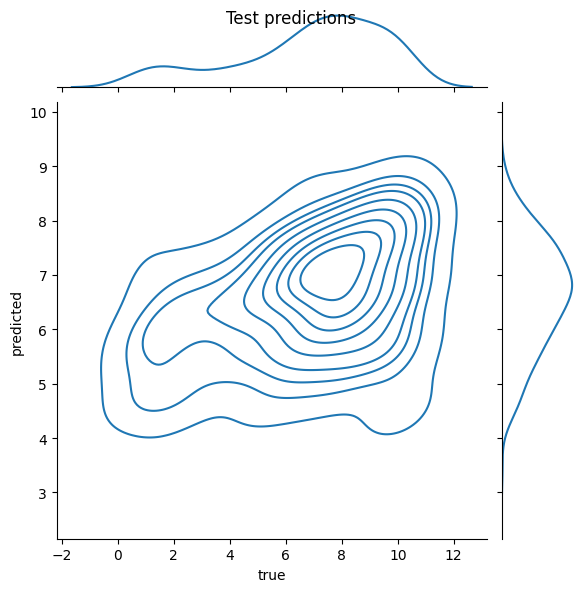

In [14]:
data=pd.DataFrame(columns=["true","predicted"])
data["true"]=true_ratings
data["predicted"]=est_ratings
g = sns.jointplot(data=data,x="true", y="predicted", kind="kde",)
g.fig.suptitle('Test predictions',fontsize=12)
plt.show()

# Recommend unseen movies for test set users

In [15]:
users=list(set(uids))
print(users[0:5])

[0, 6, 10, 12, 16]


In [16]:
anime=pd.read_csv('/kaggle/input/cellphones-recommendations/cellphones data.csv')
mapping = dict(zip(anime['cellphone_id'],anime['model']))

In [17]:
# items which the user not yet evaluate
items = trainset.build_anti_testset()
for user in users[0:5]:
    user_items = list(filter(lambda x: x[0] == user, items))
    print()
    print(user,len(user_items))
    # generate recommendation
    recommendations = algo.test(user_items)
    recommendations.sort(key=operator.itemgetter(3), reverse=True)
    print(f"User {user} recommendations:")
    for r in recommendations[0:5]:
        print(f" [Title] {mapping[r[1]]}, [Estimated Rating] {round(r[3],3)}")


0 27
User 0 recommendations:
 [Title] 11T Pro, [Estimated Rating] 6.523
 [Title] iPhone 13 Pro Max, [Estimated Rating] 6.249
 [Title] iPhone 13, [Estimated Rating] 6.228
 [Title] Galaxy S22 Ultra, [Estimated Rating] 6.142
 [Title] Find X5 Pro, [Estimated Rating] 6.056

6 26
User 6 recommendations:
 [Title] iPhone 13 Pro, [Estimated Rating] 7.397
 [Title] iPhone 13, [Estimated Rating] 7.231
 [Title] iPhone 13 Mini, [Estimated Rating] 6.836
 [Title] iPhone SE (2022), [Estimated Rating] 6.721
 [Title] Nord N20, [Estimated Rating] 6.605

10 27
User 10 recommendations:
 [Title] iPhone 13, [Estimated Rating] 8.169
 [Title] 11T Pro, [Estimated Rating] 7.909
 [Title] Find X5 Pro, [Estimated Rating] 7.881
 [Title] iPhone SE (2022), [Estimated Rating] 7.817
 [Title] Nord 2T, [Estimated Rating] 7.761

12 25
User 12 recommendations:
 [Title] iPhone 13 Pro, [Estimated Rating] 7.512
 [Title] Find X5 Pro, [Estimated Rating] 6.928
 [Title] iPhone 13, [Estimated Rating] 6.917
 [Title] 11T Pro, [Estima